In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *
from tqdm import tqdm
from post_processing import get_output

## Read TIC catalog

In [4]:
tic = pd.read_csv('../tic_catalog.txt',sep='\t')
tic.head()

,tic_id,GAIAmag,gaiabp,gaiarp,d,e_d,plx,e_plx,Tmag,e_Tmag,Bmag,e_Bmag,Vmag,lum,lumclass,Teff
0,269273552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.745,0.134,0.557,0.121,0.346457,0.023,NaN,3601.63
1,175934060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.679,0.168,0.530,0.142,NaN,NaN,NaN,NaN
2,459832522,NaN,NaN,NaN,11.2575,0.0684,88.83,0.54,-1.254,0.167,NaN,NaN,-0.103570,0.023,GIANT,4279.96
3,245873777,NaN,NaN,NaN,20.4332,0.3214,48.94,0.77,-1.200,0.209,0.375,0.208,0.872000,0.023,GIANT,3902.56
4,272314138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.043,0.170,0.354,0.149,NaN,NaN,GIANT,NaN


### Reading in `eleanor-lite` output file

In [5]:
data = get_output('../eleanor-lite-combined-v3.txt')
# data = pd.read_csv('../eleanor-lite-combined-v3.txt',sep=' ',header=None)
# with open("colnames.json", "r") as f:
#         check = f.read()
#         columns = json.loads(check)
#         columns = columns["column_names"]
# data.columns = columns
# data.head()

In [6]:
len_data = len(data)
len_data

15477322

### Importing older one for comparison

In [7]:
# df2 = pd.read_csv('../combined_dataframe_xrp.txt', header=None)
# len_df2 = len(df2)
# with open("colnames.json", "r") as f:
#         check = f.read()
#         columns = json.loads(check)
#         columns = columns["column_names"]
# df2.columns = columns
# df2 = df2[df2.transit_prob == 'maybeTransit']
# df2 = df2[(df2.asym_score <= 3)].reset_index(drop=True)
# print(f"{(len(df2)/len_df2)*100} candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.")

### Importing metadata

In [8]:
# metadata = pd.read_csv('../metadata_eleanor-lite.txt',sep=',')
# len_metadata = len(metadata)

In [9]:
# metadata.drop_duplicates(inplace=True)
# print(f"{len_metadata - len(metadata)} duplicates.")

In [10]:
#len(metadata.tic_id.unique())

### Cleaning main dataframe

In [11]:
data.drop_duplicates(inplace=True)
print(f"{len_data - len(data)} duplicates.")

0 duplicates.


In [12]:
data = data[data.transit_prob == 'maybeTransit']
data = data[(data.asym_score <= 3)].reset_index(drop=True)
data['Sector'] = data['path'].str.extract(r'/s(\d+)/').astype(int)
data.insert(2, 'Sector', data.pop('Sector'))
print(f"{(len(data)/len_data)*100}% candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.")

41.500835868117235% candidates remain from `maybeTransit` criteria and filtering out `asym_score >=3`.


In [13]:
#data.columns

In [14]:
# test = pd.merge(data,metadata,left_on=['TIC_ID','Sector'],right_on=['tic_id','sector'])
# test

In [15]:
len(data)

6423218

## Distribution of main dataframe

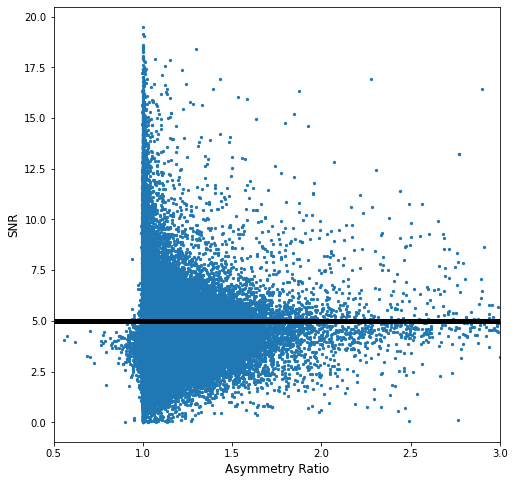

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(data.sample(frac=0.05, random_state=42).asym_score, abs(data.sample(frac=0.05, random_state=42).snr), s=5)
plt.xlabel("Asymmetry Ratio",fontsize=12)
plt.ylabel("SNR",fontsize=12)
plt.axhline(y=5,linewidth=5,color='black')
plt.xlim([0.5,3])
plt.savefig('../dist-all-maybetransits.pdf',dpi=100,transparent=True,bbox_inches='tight',rasterize=True)
plt.show()

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
ax[0].scatter(data.asym_score,abs(data.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[0].axhline(y=5,linewidth=5,color='black')
ax[1].scatter(data.skewness,abs(data.snr),s=5)
plt.show()


KeyboardInterrupt



### Comparison with XRP dataframe

In [15]:
# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
# ax[0].scatter(data.asym_score,abs(data.snr),s=2,zorder=3)
# ax[0].scatter(df2.asym_score,abs(df2.snr),s=2,zorder=3)
# ax[0].set_xlabel("asymmetry")
# ax[0].set_ylabel("snr")
# ax[1].set_xlabel("skewness")
# ax[1].scatter(data.skewness,abs(data.snr),s=2,zorder=3)
# ax[1].scatter(df2.skewness,abs(df2.snr),s=2,zorder=2)

# plt.show()

## SNR Cut 

In [16]:
data_new = data[data.snr <= 0]
data_new = data[(abs(data.snr) >= 5) & (data.asym_score > 0.8)].reset_index(drop=True)
print(f"{len(data_new)} candidates remain, {((len(data_new)/len_data)*100)} from main sample.")

552758 candidates remain, 3.571405957697333 from main sample.


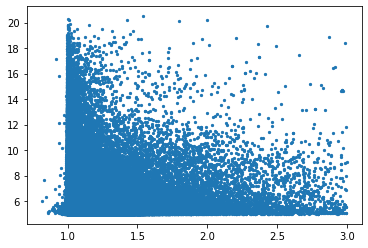

In [17]:
plt.scatter(data_new.asym_score,abs(data_new.snr),s=5)

In [18]:
tqdm.pandas()

data_new['abs_path'] = data_new['path'].progress_apply(lambda x: x.replace('/tmp/eleanor-lite/', '/storage/astro2/phrdhx/eleanor-lite-project-v2/'))

100%|██████████| 552758/552758 [00:00<00:00, 882718.37it/s]


In [19]:
data_new

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,chisq_gauss,chisq_skew,rchisq_gauss,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob,abs_path
0,/tmp/eleanor-lite/s0019/hlsp_gsfc-eleanor-lite...,348375105,19,-9.79969,-5.06893,1821.30783,1.33935,0.00467,0.37745,30.00000,...,93.21363,69.63431,1.01319,0.75689,0.00321,0.00277,0.00248,0.00225,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
1,/tmp/eleanor-lite/s0019/hlsp_gsfc-eleanor-lite...,265749158,19,-15.12507,-5.76920,1821.32864,1.52885,0.00215,0.44400,18.25307,...,1293.97878,845.69412,12.44210,8.13167,0.00099,0.00080,0.00076,0.00060,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
2,/tmp/eleanor-lite/s0019/hlsp_gsfc-eleanor-lite...,470310338,19,-7.06476,-5.64976,1832.32821,1.00625,0.00012,0.06194,-6.93738,...,94.65659,94.06756,1.02888,1.02247,0.00053,0.00053,0.00043,0.00042,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
3,/tmp/eleanor-lite/s0019/hlsp_gsfc-eleanor-lite...,78968858,19,-7.60807,-5.37455,1839.70397,1.00001,0.00011,0.01825,-3.16022,...,5893.59370,5893.54715,294.67969,294.67736,0.01476,0.01476,0.00969,0.00969,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
4,/tmp/eleanor-lite/s0019/hlsp_gsfc-eleanor-lite...,349514488,19,-12.41567,-5.27922,1833.99536,1.00169,0.00107,0.22866,-1.56525,...,273.65051,273.18247,2.04217,2.03868,0.00113,0.00112,0.00093,0.00093,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552753,/tmp/eleanor-lite/s0021/hlsp_gsfc-eleanor-lite...,159345584,21,-15.16191,-8.47856,1892.72045,1.01413,0.00390,0.03384,-0.74409,...,43.72747,43.13572,1.68183,1.65907,0.00157,0.00155,0.00113,0.00115,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
552754,/tmp/eleanor-lite/s0021/hlsp_gsfc-eleanor-lite...,416194346,21,-12.36465,-6.15822,1876.32229,1.31607,0.00131,0.56199,-30.00000,...,189.04811,143.63901,1.24374,0.94499,0.00051,0.00045,0.00040,0.00036,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
552755,/tmp/eleanor-lite/s0021/hlsp_gsfc-eleanor-lite...,373675149,21,-6.91033,-5.52177,1881.07618,1.00000,0.00041,0.07326,-0.19815,...,37.32145,37.32138,0.74643,0.74643,0.00087,0.00087,0.00074,0.00074,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...
552756,/tmp/eleanor-lite/s0021/hlsp_gsfc-eleanor-lite...,232967040,21,-15.46073,-8.66898,1881.09659,1.08277,0.00077,0.16329,-3.82198,...,352.78468,325.83404,5.18801,4.79168,0.00059,0.00057,0.00049,0.00044,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...


In [20]:
# for i in data_new[(data_new.skewness >= 30) & (abs(data_new.snr) > 7) & (abs(data_new.duration) > 0.4)].path.head(10): #4 x 4 grid for illustration purposes
#     #print(len(data_new[(data_new.asym_score >=0.9) & (data_new.asym_score <= 1) & (abs(data_new.depth) >= 0.1)]))
#     lc, lc_info = import_lightcurve(i)
#     lc = lc['TIME','CORR_FLUX','QUALITY','FLUX_ERR','FLUX_BKG']
#     _, _ = processing(lc,lc_info=lc_info,method='median',make_plots=True)

---
### Catalog Cross-Referencing

In [21]:
ebs = pd.read_csv('../catalogs/eb_cat.txt')
tois = pd.read_csv('../catalogs/exofop_tess_tois.csv')
kepler = pd.read_csv('../catalogs/kepler_ebs.txt',skiprows=7)

tois = tois.reset_index()
tois = tois['level_0'][1:]
tois = tois.values.astype(int)

In [22]:
kepler['duration'] = kepler['period'] * kepler['pdepth']

In [23]:
ebs_found = data_new[data_new['TIC_ID'].isin(ebs['ID'])]
tois_found =  data_new[data_new['TIC_ID'].isin(tois)]

In [24]:
kepler_ebs_found = data_new[data_new['TIC_ID'].isin(ebs['ID'])]

In [25]:
# Step 1: Create a boolean mask
data_new['is_eb'] = data_new['TIC_ID'].isin(ebs['ID'])
data_new['is_toi'] = data_new['TIC_ID'].isin(tois)

In [26]:
log_peak_power = np.log10(data_new['peak_lspower'])
log_depth = np.log10(abs(data_new['depth']))

In [27]:
frac_dur = data_new.duration[(data_new.is_eb == False) & (data_new.is_toi == False)]
frac_depth = data_new.depth[(data_new.is_eb == False) & (data_new.is_toi == False)]

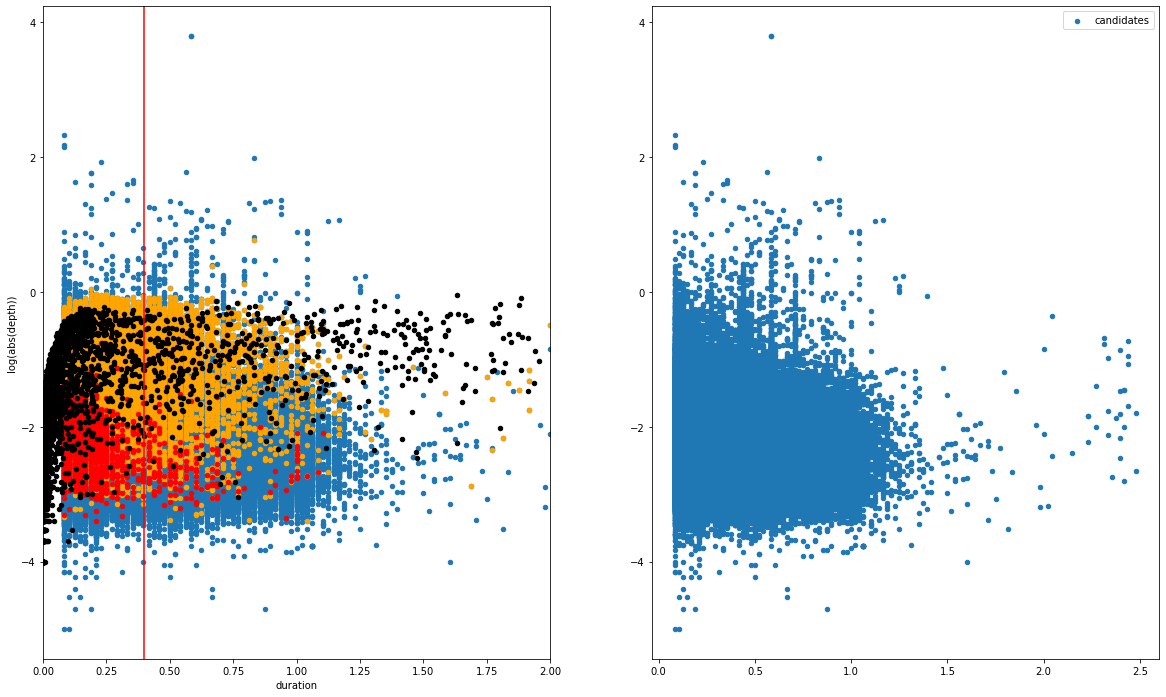

In [28]:
fig, ax = plt.subplots(ncols=2,figsize=(20,12))

ax[0].scatter(data_new.duration,log_depth,s=20,label='candidates',zorder=1)
ax[0].scatter(ebs_found.duration,np.log10(abs(ebs_found['depth'])),c='orange',s=20,label='ebs')
ax[0].scatter(tois_found.duration,np.log10(abs(tois_found['depth'])),c='red',s=20,label='tois')
ax[0].scatter(kepler.duration,np.log10(abs(kepler['pdepth'])),c='black',s=20,label='tois')

ax[1].scatter(frac_dur,np.log10(abs(frac_depth)),s=20,label='candidates',zorder=1)
#ax[1].scatter(tois_found.duration,np.log10(abs(tois_found['depth'])),c='black',s=20,label='tois')
ax[0].set_xlim([0,2])


ax[0].set_xlabel('duration')
ax[0].set_ylabel('log(abs(depth))')
ax[0].axvline(0.4,c='red')

plt.legend()

### Duration Cut (0.4 days)

In [29]:
data_new.drop(data_new[data_new['duration'] <= 0.4].index,inplace=True)
print(f"{len(data_new)} candidates remain, {((len(data_new)/len_data)*100)} from main sample.")

184826 candidates remain, 1.1941729971115158 from main sample.


### Drop all EBs

In [30]:
data_new.drop(data_new[data_new['is_eb'] == True].index,inplace=True)
print(f"{len(data_new)} candidates remain after EB cut, {((len(data_new)/len_data)*100)} from main sample.")

180864 candidates remain after EB cut, 1.1685742533495136 from main sample.


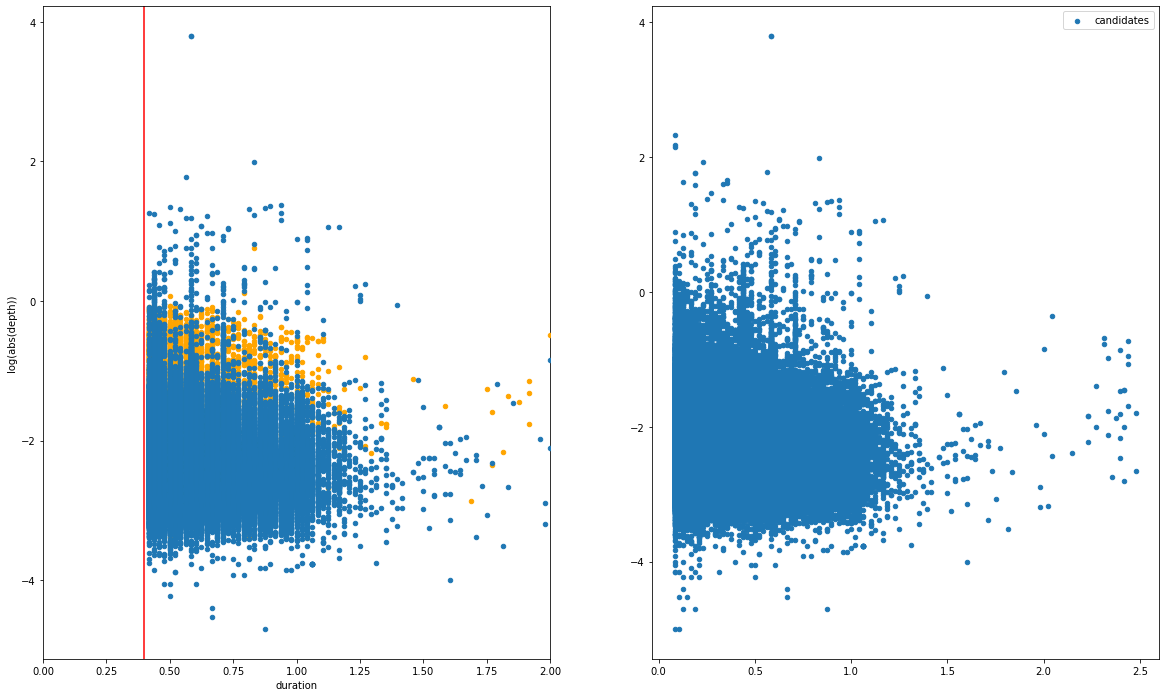

In [31]:
fig, ax = plt.subplots(ncols=2,figsize=(20,12))

ax[0].scatter(data_new.duration,np.log10(abs(data_new['depth'])),s=20,label='candidates',zorder=10)
ax[0].scatter(ebs_found[ebs_found.duration >= 0.4].duration,np.log10(abs(ebs_found[ebs_found.duration >= 0.4]['depth'].values)),c='orange',s=20,label='ebs',zorder=5)
#ax[0].scatter(tois_found.duration,np.log10(abs(tois_found['depth'])),c='black',s=20,label='tois')
#ax[0].scatter(kepler.duration,np.log10(abs(kepler['pdepth'])),c='black',s=20,label='tois')

ax[1].scatter(frac_dur,np.log10(abs(frac_depth)),s=20,label='candidates',zorder=1)
#ax[1].scatter(tois_found.duration,np.log10(abs(tois_found['depth'])),c='black',s=20,label='tois')
ax[0].set_xlim([0,2])


ax[0].set_xlabel('duration')
ax[0].set_ylabel('log(abs(depth))')
ax[0].axvline(0.4,c='red')

plt.legend()

#### We have now cut out all binaries.

### Depth Cut (1%)

In [32]:
data_new.drop(data_new[data_new['depth'] > 0].index,inplace=True)
data_new['abs_depth'] = abs(data_new.depth)
data_new.drop(data_new[(data_new['abs_depth'] >= 0.01)].index,inplace=True)
print(f"{len(data_new)} candidates remain, {((len(data_new)/len_data)*100)} from main sample.")

123195 candidates remain, 0.7959710342654885 from main sample.


In [33]:
#data_new.to_csv('../eleanor-lite-v3_candidates.csv',index=False)

---
## Distributions for sub 1% transits only

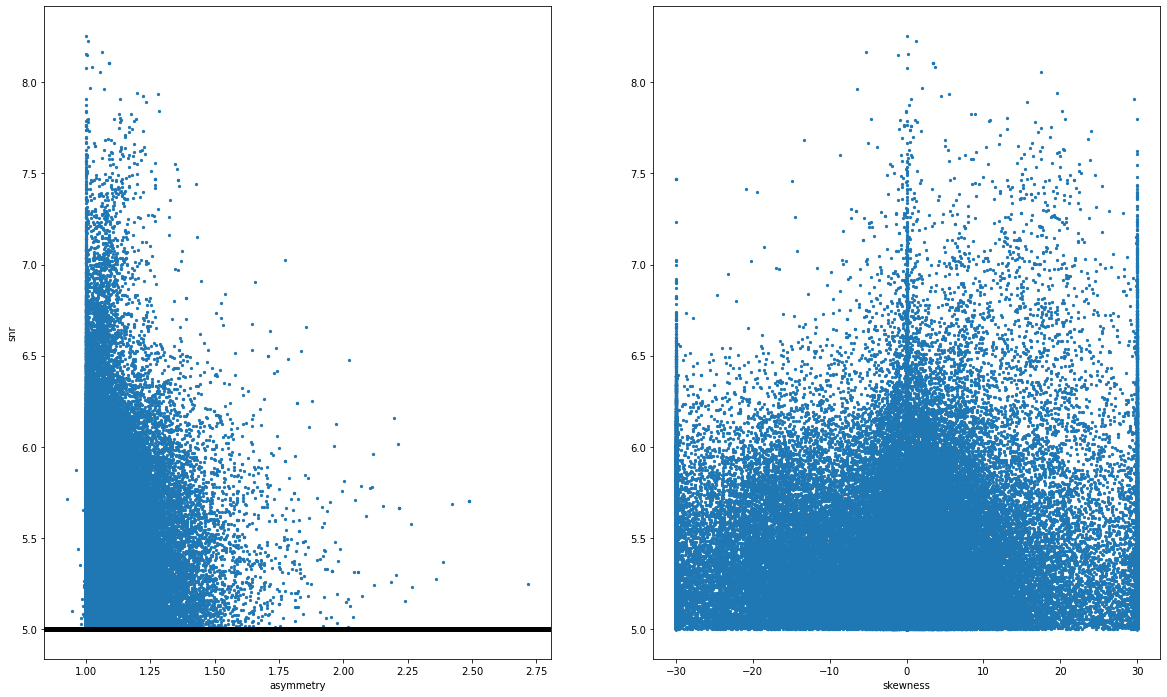

remaining candidates: 123195


In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))
ax[0].scatter(data_new.asym_score,abs(data_new.snr),s=5)
ax[0].set_xlabel("asymmetry")
ax[1].set_xlabel("skewness")
ax[0].set_ylabel("snr")
ax[0].axhline(y=5,linewidth=5,color='black')
ax[1].scatter(data_new.skewness,abs(data_new.snr),s=5)
plt.show()
print(f"remaining candidates: {len(data_new)}")

In [25]:
# for i in data_new[(data_new.asym_score >= 1) & (abs(data_new.snr) > 5)].path.head(5): #4 x 4 grid for illustration purposes
#     #print(len(data_new[(data_new.asym_score >=0.9) & (data_new.asym_score <= 1) & (abs(data_new.depth) >= 0.1)]))
#     lc, lc_info = import_lightcurve(i)
#     lc = lc['TIME','CORR_FLUX','QUALITY','FLUX_ERR','FLUX_BKG']
#     _, _ = processing(lc,lc_info=lc_info,method='median',make_plots=True)

---

In [26]:
data_new.head()

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,rchisq_skew,rmse_gauss,rmse_skew,mae_gauss,mae_skew,transit_prob,abs_path,is_eb,is_toi,abs_depth
14,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,101040310,3,-8.84133,-5.03004,1404.47203,0.98469,0.00027,0.30622,-29.99257,...,0.69477,0.00020,0.00020,0.00015,0.00015,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00069
57,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,140686847,3,-11.61651,-5.09832,1391.49037,1.16161,0.00179,0.35167,-13.93521,...,1.38528,0.00129,0.00120,0.00098,0.00090,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00396
70,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,142305477,3,-12.64399,-5.19826,1404.47261,1.20060,0.00059,0.46274,-30.00000,...,1.41786,0.00027,0.00025,0.00021,0.00017,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00100
104,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,149217216,3,-7.54512,-5.09955,1404.15728,1.04955,0.00038,0.26985,-30.00000,...,0.50710,0.00063,0.00061,0.00050,0.00048,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00111
173,/tmp/eleanor-lite/s0003/hlsp_gsfc-eleanor-lite...,142218811,3,-12.39479,-5.20685,1404.47244,1.01238,0.00051,0.43465,-30.00000,...,2.11082,0.00025,0.00025,0.00019,0.00019,maybeTransit,/storage/astro2/phrdhx/eleanor-lite-project-v2...,False,False,0.00093


In [27]:
import seaborn as sns

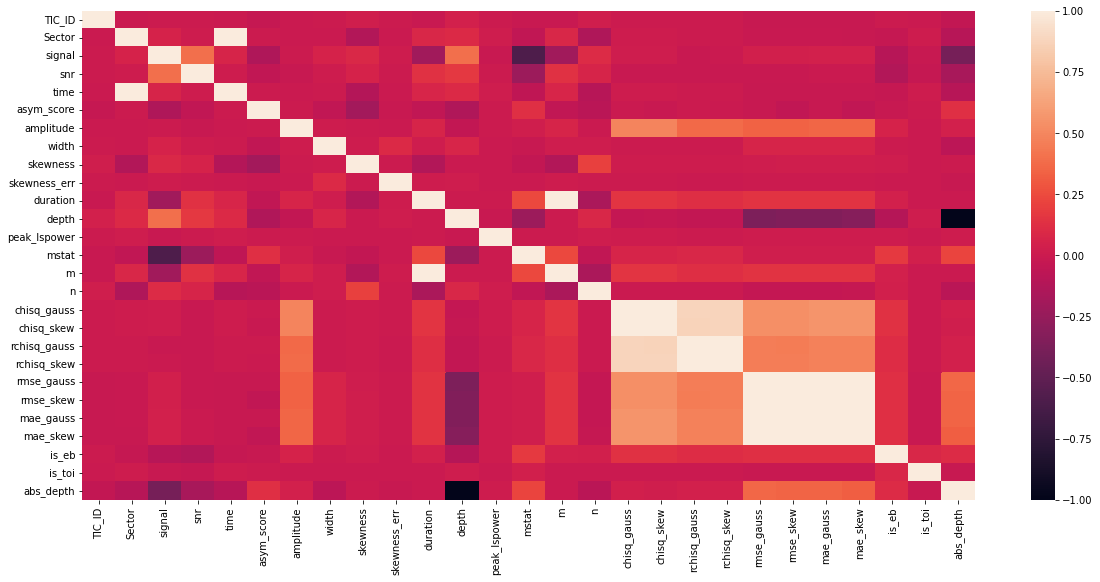

In [28]:
correlations = data_new.corr()
plt.figure(figsize=(20,9))
sns.heatmap(correlations)

In [29]:
target_variable = 'time'  
highly_correlated_columns = correlations[correlations[target_variable] > 0.5].index.tolist()

In [30]:
highly_correlated_columns


['Sector', 'time']

### Distributions over all sectors

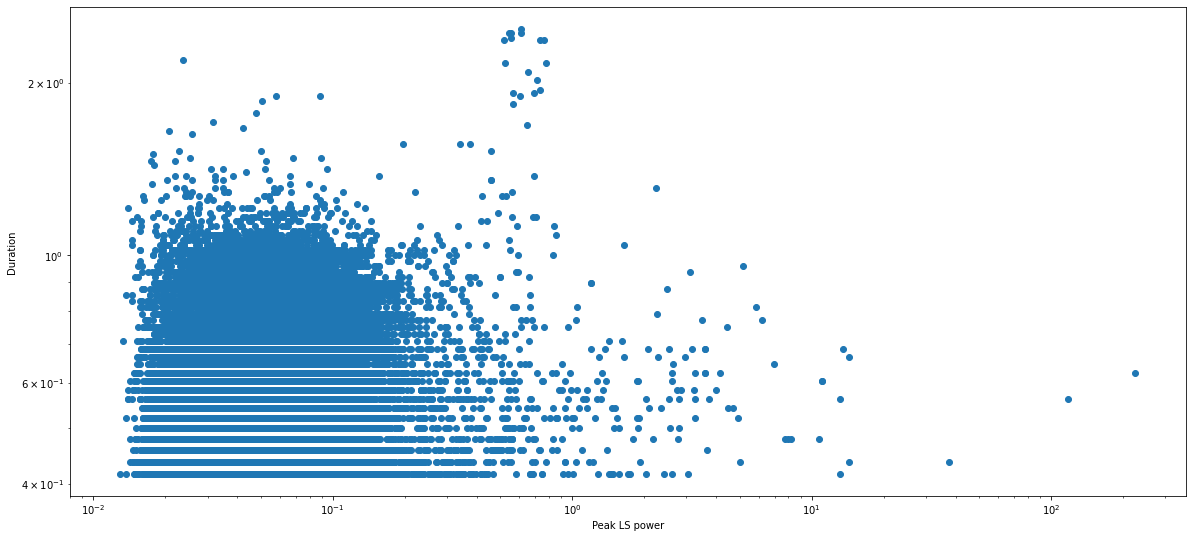

In [56]:
plt.figure(figsize=(20,9))
plt.scatter(data_new.peak_lspower,data_new.duration)
#plt.xlim([0,10])
plt.xlabel('Peak LS power')
plt.ylabel('Duration')
plt.xscale('log')
plt.yscale('log')

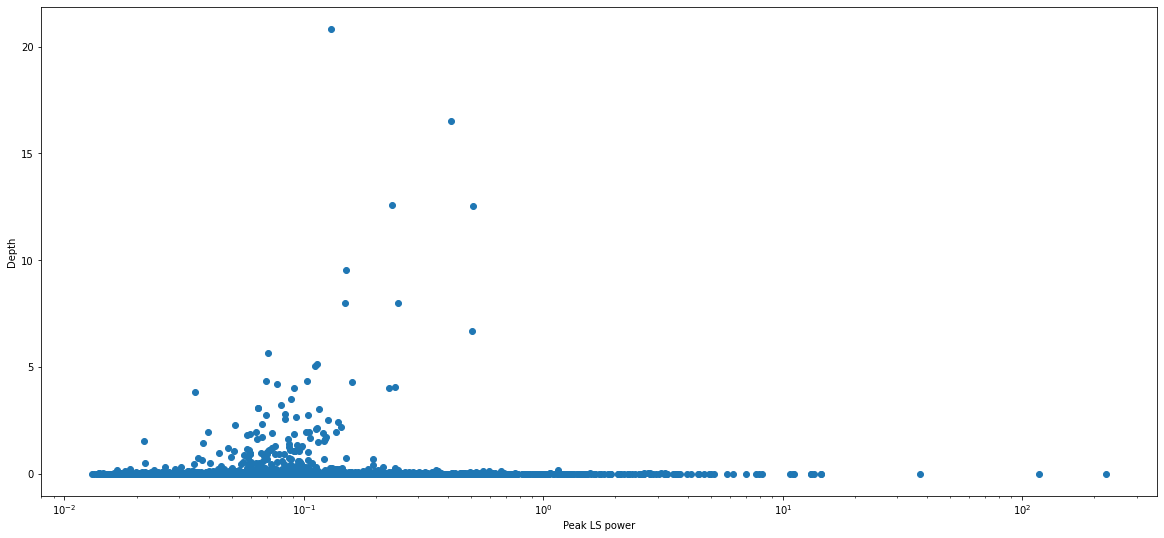

In [59]:
plt.figure(figsize=(20,9))
plt.scatter(data_new.peak_lspower,abs(data_new.depth))
plt.xlabel('Peak LS power')
plt.ylabel('Depth')
plt.xscale('log')
#plt.yscale('log')


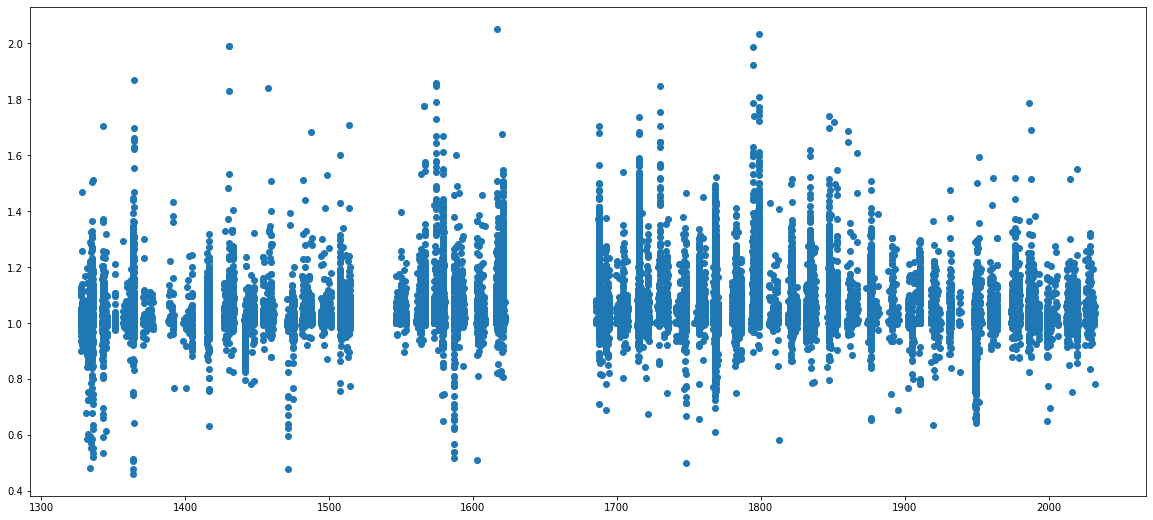

In [33]:
plt.figure(figsize=(20,9))
plt.scatter(data_new.time,data_new.asym_score)

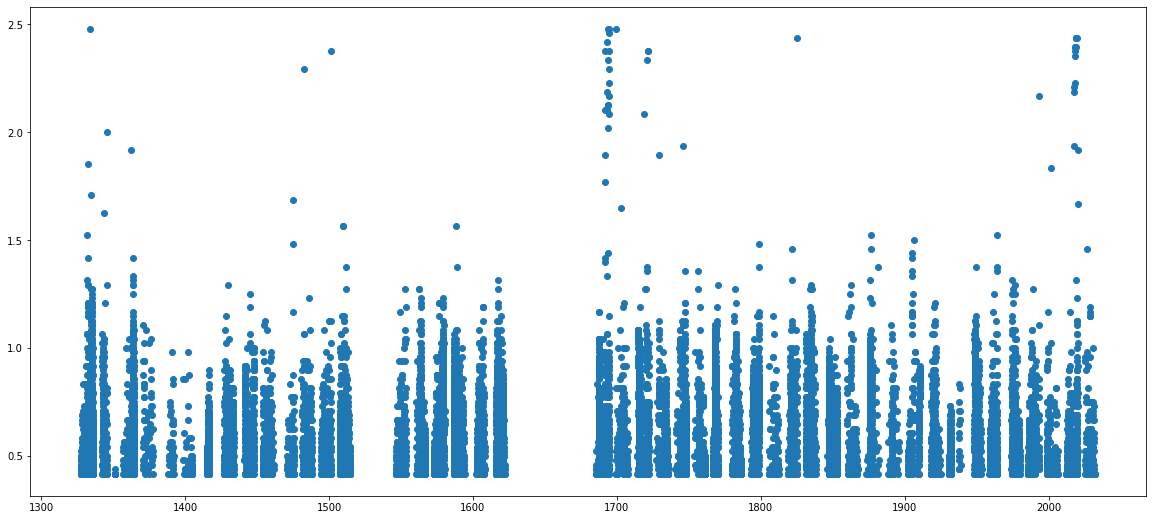

In [32]:
plt.figure(figsize=(20,9))
plt.scatter(data_new.time,data_new.duration)

---

### Splitting data up into Sectors

In [34]:
sector_data = {}

# Get unique values from the 'Sector' column
sector_values = sorted(data_new['Sector'].unique())

# Iterate through each unique sector value and create dataframes
for sector in sector_values:
    # Create a reference to the subset of the original DataFrame for the current sector
    sector_df = data_new[data_new['Sector'] == sector]
    
    # You can perform any additional data manipulation or filtering here if needed
    
    # Store the sector DataFrame in the dictionary with a meaningful key
    sector_data[f'S{sector}'] = sector_df

In [38]:
def plot_diagnostics(*condition, number_to_plot=5):
     for cond in condition:
        for i in data_new[cond].abs_path.head(number_to_plot):
            lc, lc_info = import_lightcurve(i)
            print(lc_info)
            lc = lc['TIME', 'CORR_FLUX', 'QUALITY', 'FLUX_ERR', 'FLUX_BKG']
            _, _ = processing(lc, lc_info=lc_info, method='median', make_plots=True)

[157263125, 999, 15, 4, 4, 197.583113704248, 59.3832414304277]
TIC not in search: ['.', '157263125', '-4.7931', '-5.02627', '1721.71614', '0.97678', '0.05571', '4.19601', '-0.00996', '82281.61726', '2.375', '-0.0053', '0.64176', '0.662', '114', '479', '2661715.00631', '2652656.06601', '3914.28677', '3900.9648', '0.02924', '0.02959', '0.02312', '0.02454', 'maybeTransit']


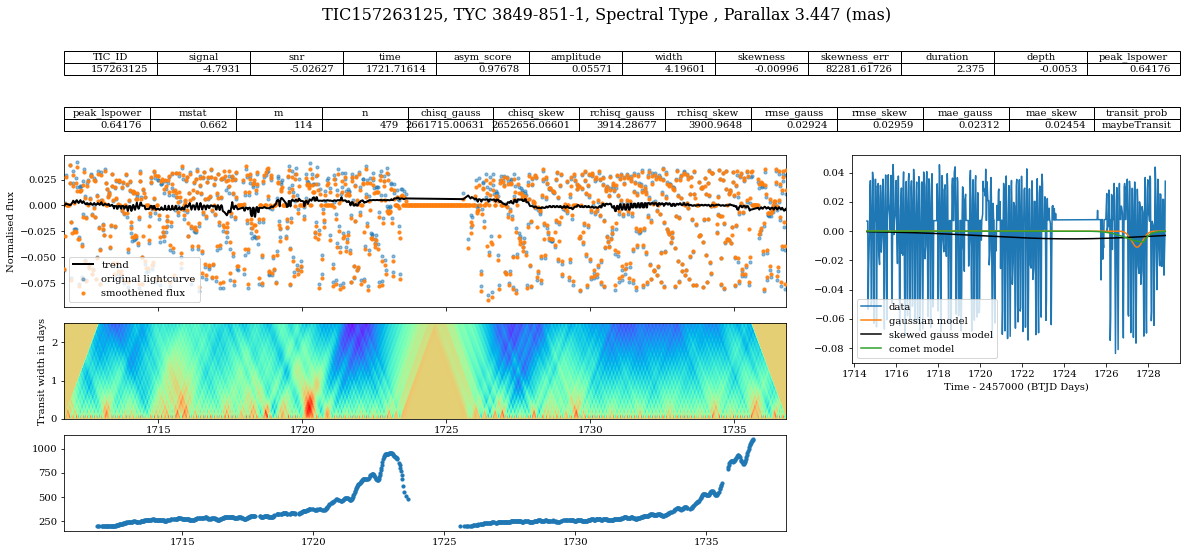

[157263126, 999, 15, 4, 4, 197.584550932611, 59.3815072640615]
TIC not in search: ['.', '157263126', '-4.79313', '-5.0268', '1721.71614', '0.97678', '0.05571', '4.19612', '-0.00918', '97136.71132', '2.375', '-0.0053', '0.64177', '0.662', '114', '479', '2661722.07559', '2652665.04686', '3914.29717', '3900.97801', '0.02924', '0.02959', '0.02312', '0.02454', 'maybeTransit']


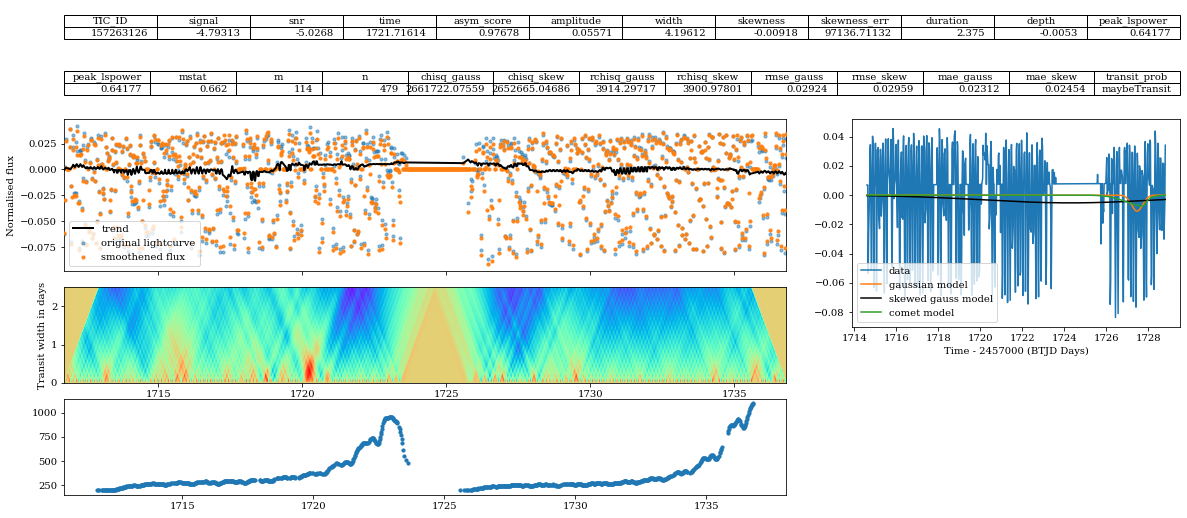

[295897116, 999, 15, 2, 4, 304.254999195903, 52.8780106474463]
TIC not in search: ['.', '295897116', '-4.71079', '-5.37863', '1718.76296', '0.99325', '0.2188', '97.34793', '29.99251', '9795.36096', '2.08334', '-0.00178', '0.65527', '0.498', '100', '325', '134831.36998', '134540.46575', '226.22713', '225.73904', '0.00735', '0.00737', '0.00573', '0.00595', 'maybeTransit']


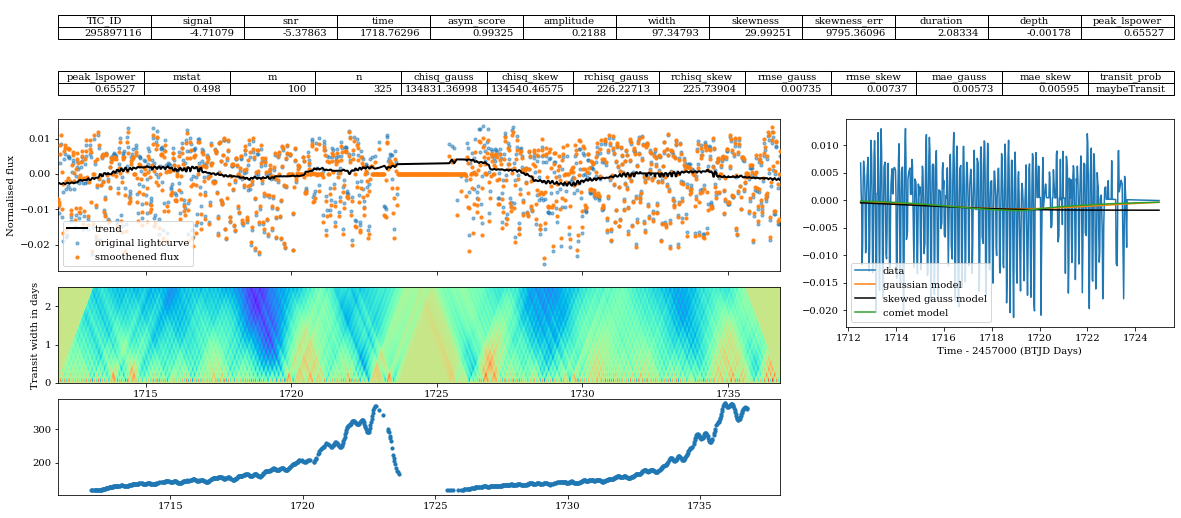

[272082148, 999, 15, 2, 3, 296.147395654836, 46.6185498833943]
TIC not in search: ['.', '272082148', '-5.04901', '-5.43199', '1721.24232', '0.99236', '0.08666', '3.46933', '0.00363', '310823.92038', '2.33331', '-0.00996', '0.68315', '0.714', '112', '444', '220405.25434', '219839.72536', '329.94799', '329.10139', '0.03978', '0.03993', '0.03161', '0.03252', 'maybeTransit']


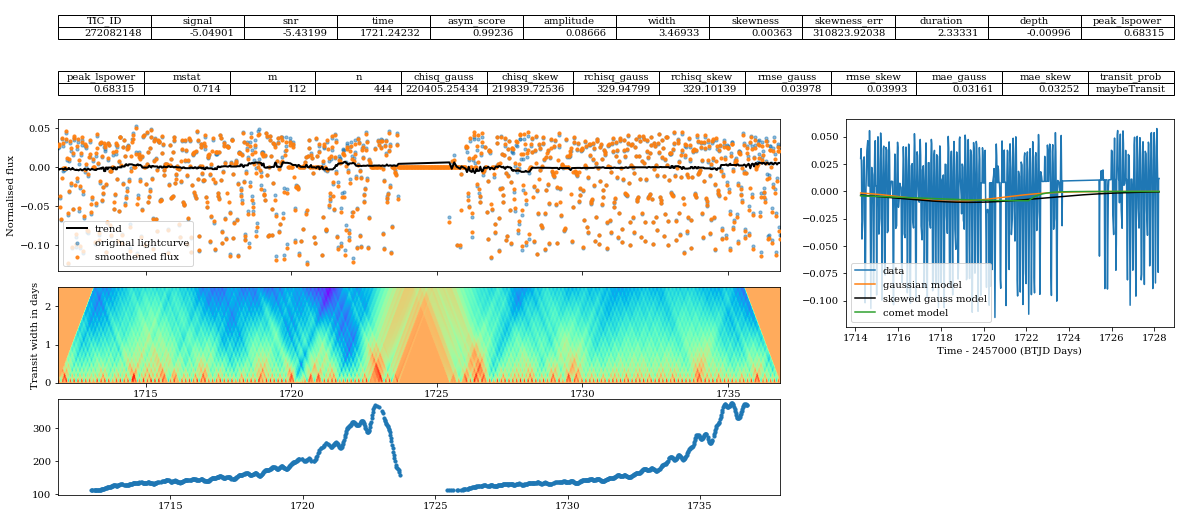

[86233324, 999, 14, 4, 3, 139.715406544474, 65.24747040684841]
TIC not in search: ['.', '86233324', '-4.08007', '-5.58843', '1691.44437', '1.0', '0.00087', '0.0085', '-29.20154', '0.0', '2.1042', '-0.00924', '0.52496', '0.419', '101', '364', '25608.07578', '25608.07965', '42.53833', '42.53834', '0.00474', '0.00474', '0.00341', '0.00341', 'maybeTransit']


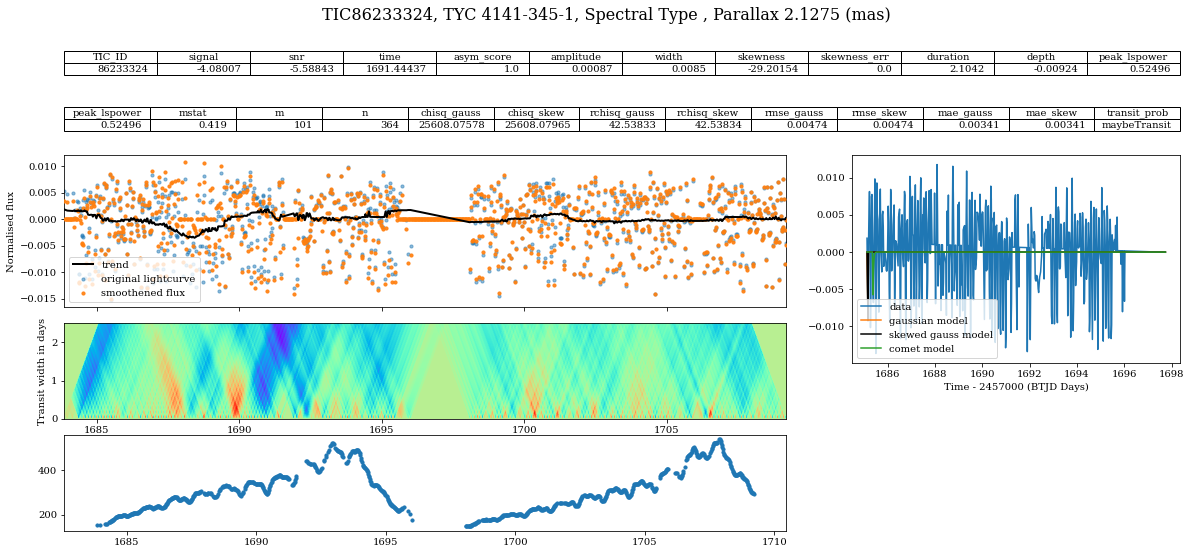

In [41]:
plot_diagnostics(data_new.duration >= 2)